## Model Training for The Business Problem
Business Problem: What is the likelihood of booking to be performed.<br>
What Needs To Be Done: Calculate the likelihood of a user to perform booking. It is a binary classification problem
### My Approach
First of all, I thought about splitting  the dataset according to the time frame. I thought I could use the first 16 days as train data and the last 4 days as validation data and my model would predict the bookings for the next 4 days. Then I decided that data size and time period of 20 days is not sufficient  for this approach.
Then I decided to predict booking likelihood without considering any time frame.

I have chosen 'is_booked' as target variable. I have dropped 'booked' feature which indicates no of bookings performed by a user. Because it is an obvious clue for 'is_booking' target.
I have used %20 of data as validation dataset.
### Model
I thought I can utilize trees for this kind of binary classification. I have chosen Lightgbm because it is easy to use and I am familiar with it.

Before running the training I have used Hyperopt to find out optimal parameters for Lightgbm. But I did not want Hyperopt to decide on learning rate since it can cause overfitting. I have changed the learning rate and l1 regularization value according to the standard deviation of cross-validation results.

The objective was obviously 'Binary' and I thought for likelihood calculation it is a good idea to utilize log loss. 

### Important Features
I have utilized Lightgbm's importance plot to find out the most important features. Below you could find top 3 features:

<b>origin_lat:</b> I am a little bit surprised that this is the most important feature. I was expecting search has the most effect on booking decisions. But it seems that the latitude of the origin has more importance.<br>
<b>searched:</b> It was an expected result for me. Users who performed searches would be more likely to book a vacation.<br>
<b>origin_lon:</b>  It seems that this feature is also important for booking decisions like origin_lat.<br>

### Evaluation
I have tried different evaluation metrics. The model already gives me the binary log loss value.

<li>For training binary_logloss: 0.0871094	for validation binary_logloss: 0.0881209

<li>For validation dataset: AUC is 0.96916, rmse is 0.02347, precision is 0.97849, accuracy is 0.96969 

<li>I have also tried RMSE since likelihood calculation is a kind of regression other than a classification.

<li>I think the most suitable evaluation metric for marketing binary classifications  is precision since it evaluates the accuracy of positive predictions.


### Cross-Validation

According to cross validation results min logloss is 0.0895635 maximum logloss is 0.2215380, average is 0.1149708 <br>
I am suspicious about this high accurate results. But I did not have time to dig deeper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from hyperopt import  tpe, hp,  STATUS_OK
from hyperopt.fmin import fmin
import statistics as st
%matplotlib inline

/home/him/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


## Prepare Train and Validation Datasets

In [2]:
df=pd.read_csv('user_features.csv', header=0,  quotechar='"', error_bad_lines=False)


In [3]:
#is_booked 
book=[]
for val in df['booked']:
    if val>0:
        booked=1
    else:
        booked=0
    book.append(booked)
df['is_booked']=book

In [4]:
df.head()

,user_id,num_adults,num_children,vac_duration,book_search_duration,book_days_ago,child_per_adult,vac_distance1,vac_distance2,origin_lat,...,origin_YOW,origin_YTO,origin_YUL,origin_YVR,origin_YWG,origin_YYC,origin_YYZ,origin_ZRH,user_id.1,is_booked
0,000069,2.0,3.0,16.0,10.0,1187.0,1.5,1548.008799,1548.875108,200.32,...,0,0,0,0,0,0,0,0,000069,0
1,00019d,4.0,0.0,28.0,139.0,1188.0,0.0,7932.127859,7951.952030,97.70,...,0,0,0,0,0,0,0,0,00019d,0
2,0002e3,1.0,0.0,0.0,6.0,1192.0,0.0,2107.313051,2104.104322,97.70,...,0,0,0,0,0,0,0,0,0002e3,0
3,000332,1.5,0.0,29.0,41.0,1189.0,0.0,2731.559030,2727.630372,652.34,...,0,0,0,0,0,0,0,0,000332,0
4,0004e1,1.0,0.0,6.0,80.0,1188.0,0.0,709.283337,709.657571,192.98,...,0,0,0,0,0,0,0,0,0004e1,0


In [5]:
y=df['is_booked']
y=pd.DataFrame(y)
X=df.drop(columns=['is_booked','user_id','user_id.1','booked','vac_distance1'])

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

## Tunning Lightgbm Parameters With HyperOpt

In [211]:
# try different values in order to prevent overfitting
# change the value according to cross validation results
lr=0.003 # learning_rate value
l1=0.0007 #l1 regularization to prevent overfitting

In [212]:
def error(params):

    dtrain = lightgbm.Dataset(X_train, label=y_train)
    dval = lightgbm.Dataset(X_val, label=y_val, reference=dtrain)

    params = {
         'objective': 'binary', #rank:pairwise', # softmax
         'metric': ['binary_logloss'],
         'learning_rate' : lr,
         'lambda_l1' : l1,
         'boosting': 'gbdt'
        }


    
    evallist = [dtrain, dval]

    num_epochs = 40
    eval_data = {}

    model = lightgbm.train(
        params,
        dtrain,
        num_epochs,
        evallist,
        evals_result=eval_data,
        verbose_eval=True
    )
    #print(eval_data, type(eval_data))
    l=(eval_data['valid_1']['binary_logloss'])
    laerr=min(l)
    #laerr=sum(l) / float(len(l))
    #laerr=l[-1]
    return {'loss':laerr, 'status': STATUS_OK}


space = {
    'max_depth': hp.uniform('max_depth', 1, 6),
    'eta': hp.uniform('eta', 0.1, 0.9),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    #'learning_rate' : hp.uniform('learning_rate', 0.001, 0.07),
    'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
    'min_child_weight': hp.loguniform('min_child_weight', -16, 5),
    'feature_fraction': hp.uniform('feature_fraction', 0.3, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.3, 1), 
}


best = fmin(fn=error,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516
[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809
[3]	training's binary_logloss: 0.214709	valid_1's binary_logloss: 0.210562
[4]	training's binary_logloss: 0.212457	valid_1's binary_logloss: 0.208412
[5]	training's binary_logloss: 0.210297	valid_1's binary_logloss: 0.206366
[6]	training's binary_logloss: 0.208242	valid_1's binary_logloss: 0.204409
[7]	training's binary_logloss: 0.20623	valid_1's binary_logloss: 0.202496
[8]	training's binary_logloss: 0.204309	valid_1's binary_logloss: 0.200665
[9]	training's binary_logloss: 0.202451	valid_1's binary_logloss: 0.198895
[10]	training's binary_logloss: 0.200638	valid_1's binary_logloss: 0.197172
[11]	training's binary_logloss: 0.198879	valid_1's binary_logloss: 0.195499
[12]	training's binary_logloss: 0.197159	valid_1's binary_logloss: 0.193879
[13]	training's binary_logloss: 0.195512	valid_1's binary_logloss: 0.192316
[14]	training's binary_

[23]	training's binary_logloss: 0.181096	valid_1's binary_logloss: 0.178649       
[24]	training's binary_logloss: 0.179826	valid_1's binary_logloss: 0.177447       
[25]	training's binary_logloss: 0.178587	valid_1's binary_logloss: 0.176259       
[26]	training's binary_logloss: 0.177369	valid_1's binary_logloss: 0.175106       
[27]	training's binary_logloss: 0.176199	valid_1's binary_logloss: 0.173987       
[28]	training's binary_logloss: 0.175031	valid_1's binary_logloss: 0.172885       
[29]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.171803        
[30]	training's binary_logloss: 0.172767	valid_1's binary_logloss: 0.170731       
[31]	training's binary_logloss: 0.171682	valid_1's binary_logloss: 0.169702       
[32]	training's binary_logloss: 0.1706	valid_1's binary_logloss: 0.168678         
[33]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.167673       
[34]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.166684        
[35]

[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516         
[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809        
[3]	training's binary_logloss: 0.214709	valid_1's binary_logloss: 0.210562        
[4]	training's binary_logloss: 0.212457	valid_1's binary_logloss: 0.208412        
[5]	training's binary_logloss: 0.210297	valid_1's binary_logloss: 0.206366        
[6]	training's binary_logloss: 0.208242	valid_1's binary_logloss: 0.204409        
[7]	training's binary_logloss: 0.20623	valid_1's binary_logloss: 0.202496         
[8]	training's binary_logloss: 0.204309	valid_1's binary_logloss: 0.200665        
[9]	training's binary_logloss: 0.202451	valid_1's binary_logloss: 0.198895        
[10]	training's binary_logloss: 0.200638	valid_1's binary_logloss: 0.197172       
[11]	training's binary_logloss: 0.198879	valid_1's binary_logloss: 0.195499       
[12]	training's binary_logloss: 0.197159	valid_1's binary_logloss: 0.193879       
[13]

[19]	training's binary_logloss: 0.186419	valid_1's binary_logloss: 0.183702       
[20]	training's binary_logloss: 0.185057	valid_1's binary_logloss: 0.182406       
[21]	training's binary_logloss: 0.183699	valid_1's binary_logloss: 0.181123       
[22]	training's binary_logloss: 0.182373	valid_1's binary_logloss: 0.179865       
[23]	training's binary_logloss: 0.181096	valid_1's binary_logloss: 0.178649       
[24]	training's binary_logloss: 0.179826	valid_1's binary_logloss: 0.177447       
[25]	training's binary_logloss: 0.178587	valid_1's binary_logloss: 0.176259       
[26]	training's binary_logloss: 0.177369	valid_1's binary_logloss: 0.175106       
[27]	training's binary_logloss: 0.176199	valid_1's binary_logloss: 0.173987       
[28]	training's binary_logloss: 0.175031	valid_1's binary_logloss: 0.172885       
[29]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.171803        
[30]	training's binary_logloss: 0.172767	valid_1's binary_logloss: 0.170731       
[31]

[37]	training's binary_logloss: 0.165499	valid_1's binary_logloss: 0.163817       
[38]	training's binary_logloss: 0.164527	valid_1's binary_logloss: 0.162884       
[39]	training's binary_logloss: 0.163569	valid_1's binary_logloss: 0.161978       
[40]	training's binary_logloss: 0.162662	valid_1's binary_logloss: 0.161117       
[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516          
[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809         
[3]	training's binary_logloss: 0.214709	valid_1's binary_logloss: 0.210562         
[4]	training's binary_logloss: 0.212457	valid_1's binary_logloss: 0.208412         
[5]	training's binary_logloss: 0.210297	valid_1's binary_logloss: 0.206366         
[6]	training's binary_logloss: 0.208242	valid_1's binary_logloss: 0.204409         
[7]	training's binary_logloss: 0.20623	valid_1's binary_logloss: 0.202496          
[8]	training's binary_logloss: 0.204309	valid_1's binary_logloss: 0.200665      

[14]	training's binary_logloss: 0.193892	valid_1's binary_logloss: 0.190781        
[15]	training's binary_logloss: 0.192327	valid_1's binary_logloss: 0.189292        
[16]	training's binary_logloss: 0.190787	valid_1's binary_logloss: 0.187839        
[17]	training's binary_logloss: 0.189303	valid_1's binary_logloss: 0.186419        
[18]	training's binary_logloss: 0.187843	valid_1's binary_logloss: 0.185044        
[19]	training's binary_logloss: 0.186419	valid_1's binary_logloss: 0.183702        
[20]	training's binary_logloss: 0.185057	valid_1's binary_logloss: 0.182406        
[21]	training's binary_logloss: 0.183699	valid_1's binary_logloss: 0.181123        
[22]	training's binary_logloss: 0.182373	valid_1's binary_logloss: 0.179865        
[23]	training's binary_logloss: 0.181096	valid_1's binary_logloss: 0.178649        
[24]	training's binary_logloss: 0.179826	valid_1's binary_logloss: 0.177447        
[25]	training's binary_logloss: 0.178587	valid_1's binary_logloss: 0.176259 

[31]	training's binary_logloss: 0.171682	valid_1's binary_logloss: 0.169702        
[32]	training's binary_logloss: 0.1706	valid_1's binary_logloss: 0.168678          
[33]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.167673        
[34]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.166684         
[35]	training's binary_logloss: 0.167493	valid_1's binary_logloss: 0.165721        
[36]	training's binary_logloss: 0.166483	valid_1's binary_logloss: 0.164762        
[37]	training's binary_logloss: 0.165499	valid_1's binary_logloss: 0.163817        
[38]	training's binary_logloss: 0.164527	valid_1's binary_logloss: 0.162884        
[39]	training's binary_logloss: 0.163569	valid_1's binary_logloss: 0.161978        
[40]	training's binary_logloss: 0.162662	valid_1's binary_logloss: 0.161117        
[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516          
[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809  

[8]	training's binary_logloss: 0.204309	valid_1's binary_logloss: 0.200665         
[9]	training's binary_logloss: 0.202451	valid_1's binary_logloss: 0.198895         
[10]	training's binary_logloss: 0.200638	valid_1's binary_logloss: 0.197172        
[11]	training's binary_logloss: 0.198879	valid_1's binary_logloss: 0.195499        
[12]	training's binary_logloss: 0.197159	valid_1's binary_logloss: 0.193879        
[13]	training's binary_logloss: 0.195512	valid_1's binary_logloss: 0.192316        
[14]	training's binary_logloss: 0.193892	valid_1's binary_logloss: 0.190781        
[15]	training's binary_logloss: 0.192327	valid_1's binary_logloss: 0.189292        
[16]	training's binary_logloss: 0.190787	valid_1's binary_logloss: 0.187839        
[17]	training's binary_logloss: 0.189303	valid_1's binary_logloss: 0.186419        
[18]	training's binary_logloss: 0.187843	valid_1's binary_logloss: 0.185044        
[19]	training's binary_logloss: 0.186419	valid_1's binary_logloss: 0.183702 

[25]	training's binary_logloss: 0.178587	valid_1's binary_logloss: 0.176259        
[26]	training's binary_logloss: 0.177369	valid_1's binary_logloss: 0.175106        
[27]	training's binary_logloss: 0.176199	valid_1's binary_logloss: 0.173987        
[28]	training's binary_logloss: 0.175031	valid_1's binary_logloss: 0.172885        
[29]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.171803         
[30]	training's binary_logloss: 0.172767	valid_1's binary_logloss: 0.170731        
[31]	training's binary_logloss: 0.171682	valid_1's binary_logloss: 0.169702        
[32]	training's binary_logloss: 0.1706	valid_1's binary_logloss: 0.168678          
[33]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.167673        
[34]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.166684         
[35]	training's binary_logloss: 0.167493	valid_1's binary_logloss: 0.165721        
[36]	training's binary_logloss: 0.166483	valid_1's binary_logloss: 0.164762 

[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809         
[3]	training's binary_logloss: 0.214709	valid_1's binary_logloss: 0.210562         
[4]	training's binary_logloss: 0.212457	valid_1's binary_logloss: 0.208412         
[5]	training's binary_logloss: 0.210297	valid_1's binary_logloss: 0.206366         
[6]	training's binary_logloss: 0.208242	valid_1's binary_logloss: 0.204409         
[7]	training's binary_logloss: 0.20623	valid_1's binary_logloss: 0.202496          
[8]	training's binary_logloss: 0.204309	valid_1's binary_logloss: 0.200665         
[9]	training's binary_logloss: 0.202451	valid_1's binary_logloss: 0.198895         
[10]	training's binary_logloss: 0.200638	valid_1's binary_logloss: 0.197172        
[11]	training's binary_logloss: 0.198879	valid_1's binary_logloss: 0.195499        
[12]	training's binary_logloss: 0.197159	valid_1's binary_logloss: 0.193879        
[13]	training's binary_logloss: 0.195512	valid_1's binary_logloss: 0.192316 

[19]	training's binary_logloss: 0.186419	valid_1's binary_logloss: 0.183702        
[20]	training's binary_logloss: 0.185057	valid_1's binary_logloss: 0.182406        
[21]	training's binary_logloss: 0.183699	valid_1's binary_logloss: 0.181123        
[22]	training's binary_logloss: 0.182373	valid_1's binary_logloss: 0.179865        
[23]	training's binary_logloss: 0.181096	valid_1's binary_logloss: 0.178649        
[24]	training's binary_logloss: 0.179826	valid_1's binary_logloss: 0.177447        
[25]	training's binary_logloss: 0.178587	valid_1's binary_logloss: 0.176259        
[26]	training's binary_logloss: 0.177369	valid_1's binary_logloss: 0.175106        
[27]	training's binary_logloss: 0.176199	valid_1's binary_logloss: 0.173987        
[28]	training's binary_logloss: 0.175031	valid_1's binary_logloss: 0.172885        
[29]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.171803         
[30]	training's binary_logloss: 0.172767	valid_1's binary_logloss: 0.170731 

[36]	training's binary_logloss: 0.166483	valid_1's binary_logloss: 0.164762        
[37]	training's binary_logloss: 0.165499	valid_1's binary_logloss: 0.163817        
[38]	training's binary_logloss: 0.164527	valid_1's binary_logloss: 0.162884        
[39]	training's binary_logloss: 0.163569	valid_1's binary_logloss: 0.161978        
[40]	training's binary_logloss: 0.162662	valid_1's binary_logloss: 0.161117        
[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516          
[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809         
[3]	training's binary_logloss: 0.214709	valid_1's binary_logloss: 0.210562         
[4]	training's binary_logloss: 0.212457	valid_1's binary_logloss: 0.208412         
[5]	training's binary_logloss: 0.210297	valid_1's binary_logloss: 0.206366         
[6]	training's binary_logloss: 0.208242	valid_1's binary_logloss: 0.204409         
[7]	training's binary_logloss: 0.20623	valid_1's binary_logloss: 0.202496   

[13]	training's binary_logloss: 0.195512	valid_1's binary_logloss: 0.192316        
[14]	training's binary_logloss: 0.193892	valid_1's binary_logloss: 0.190781        
[15]	training's binary_logloss: 0.192327	valid_1's binary_logloss: 0.189292        
[16]	training's binary_logloss: 0.190787	valid_1's binary_logloss: 0.187839        
[17]	training's binary_logloss: 0.189303	valid_1's binary_logloss: 0.186419        
[18]	training's binary_logloss: 0.187843	valid_1's binary_logloss: 0.185044        
[19]	training's binary_logloss: 0.186419	valid_1's binary_logloss: 0.183702        
[20]	training's binary_logloss: 0.185057	valid_1's binary_logloss: 0.182406        
[21]	training's binary_logloss: 0.183699	valid_1's binary_logloss: 0.181123        
[22]	training's binary_logloss: 0.182373	valid_1's binary_logloss: 0.179865        
[23]	training's binary_logloss: 0.181096	valid_1's binary_logloss: 0.178649        
[24]	training's binary_logloss: 0.179826	valid_1's binary_logloss: 0.177447 

[30]	training's binary_logloss: 0.172767	valid_1's binary_logloss: 0.170731        
[31]	training's binary_logloss: 0.171682	valid_1's binary_logloss: 0.169702        
[32]	training's binary_logloss: 0.1706	valid_1's binary_logloss: 0.168678          
[33]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.167673        
[34]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.166684         
[35]	training's binary_logloss: 0.167493	valid_1's binary_logloss: 0.165721        
[36]	training's binary_logloss: 0.166483	valid_1's binary_logloss: 0.164762        
[37]	training's binary_logloss: 0.165499	valid_1's binary_logloss: 0.163817        
[38]	training's binary_logloss: 0.164527	valid_1's binary_logloss: 0.162884        
[39]	training's binary_logloss: 0.163569	valid_1's binary_logloss: 0.161978        
[40]	training's binary_logloss: 0.162662	valid_1's binary_logloss: 0.161117        
[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516   

[7]	training's binary_logloss: 0.20623	valid_1's binary_logloss: 0.202496          
[8]	training's binary_logloss: 0.204309	valid_1's binary_logloss: 0.200665         
[9]	training's binary_logloss: 0.202451	valid_1's binary_logloss: 0.198895         
[10]	training's binary_logloss: 0.200638	valid_1's binary_logloss: 0.197172        
[11]	training's binary_logloss: 0.198879	valid_1's binary_logloss: 0.195499        
[12]	training's binary_logloss: 0.197159	valid_1's binary_logloss: 0.193879        
[13]	training's binary_logloss: 0.195512	valid_1's binary_logloss: 0.192316        
[14]	training's binary_logloss: 0.193892	valid_1's binary_logloss: 0.190781        
[15]	training's binary_logloss: 0.192327	valid_1's binary_logloss: 0.189292        
[16]	training's binary_logloss: 0.190787	valid_1's binary_logloss: 0.187839        
[17]	training's binary_logloss: 0.189303	valid_1's binary_logloss: 0.186419        
[18]	training's binary_logloss: 0.187843	valid_1's binary_logloss: 0.185044 

[24]	training's binary_logloss: 0.179826	valid_1's binary_logloss: 0.177447        
[25]	training's binary_logloss: 0.178587	valid_1's binary_logloss: 0.176259        
[26]	training's binary_logloss: 0.177369	valid_1's binary_logloss: 0.175106        
[27]	training's binary_logloss: 0.176199	valid_1's binary_logloss: 0.173987        
[28]	training's binary_logloss: 0.175031	valid_1's binary_logloss: 0.172885        
[29]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.171803         
[30]	training's binary_logloss: 0.172767	valid_1's binary_logloss: 0.170731        
[31]	training's binary_logloss: 0.171682	valid_1's binary_logloss: 0.169702        
[32]	training's binary_logloss: 0.1706	valid_1's binary_logloss: 0.168678          
[33]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.167673        
[34]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.166684         
[35]	training's binary_logloss: 0.167493	valid_1's binary_logloss: 0.165721 

[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516          
[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809         
[3]	training's binary_logloss: 0.214709	valid_1's binary_logloss: 0.210562         
[4]	training's binary_logloss: 0.212457	valid_1's binary_logloss: 0.208412         
[5]	training's binary_logloss: 0.210297	valid_1's binary_logloss: 0.206366         
[6]	training's binary_logloss: 0.208242	valid_1's binary_logloss: 0.204409         
[7]	training's binary_logloss: 0.20623	valid_1's binary_logloss: 0.202496          
[8]	training's binary_logloss: 0.204309	valid_1's binary_logloss: 0.200665         
[9]	training's binary_logloss: 0.202451	valid_1's binary_logloss: 0.198895         
[10]	training's binary_logloss: 0.200638	valid_1's binary_logloss: 0.197172        
[11]	training's binary_logloss: 0.198879	valid_1's binary_logloss: 0.195499        
[12]	training's binary_logloss: 0.197159	valid_1's binary_logloss: 0.193879 

[18]	training's binary_logloss: 0.187843	valid_1's binary_logloss: 0.185044        
[19]	training's binary_logloss: 0.186419	valid_1's binary_logloss: 0.183702        
[20]	training's binary_logloss: 0.185057	valid_1's binary_logloss: 0.182406        
[21]	training's binary_logloss: 0.183699	valid_1's binary_logloss: 0.181123        
[22]	training's binary_logloss: 0.182373	valid_1's binary_logloss: 0.179865        
[23]	training's binary_logloss: 0.181096	valid_1's binary_logloss: 0.178649        
[24]	training's binary_logloss: 0.179826	valid_1's binary_logloss: 0.177447        
[25]	training's binary_logloss: 0.178587	valid_1's binary_logloss: 0.176259        
[26]	training's binary_logloss: 0.177369	valid_1's binary_logloss: 0.175106        
[27]	training's binary_logloss: 0.176199	valid_1's binary_logloss: 0.173987        
[28]	training's binary_logloss: 0.175031	valid_1's binary_logloss: 0.172885        
[29]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.171803  

[35]	training's binary_logloss: 0.167493	valid_1's binary_logloss: 0.165721        
[36]	training's binary_logloss: 0.166483	valid_1's binary_logloss: 0.164762        
[37]	training's binary_logloss: 0.165499	valid_1's binary_logloss: 0.163817        
[38]	training's binary_logloss: 0.164527	valid_1's binary_logloss: 0.162884        
[39]	training's binary_logloss: 0.163569	valid_1's binary_logloss: 0.161978        
[40]	training's binary_logloss: 0.162662	valid_1's binary_logloss: 0.161117        
[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516          
[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809         
[3]	training's binary_logloss: 0.214709	valid_1's binary_logloss: 0.210562         
[4]	training's binary_logloss: 0.212457	valid_1's binary_logloss: 0.208412         
[5]	training's binary_logloss: 0.210297	valid_1's binary_logloss: 0.206366         
[6]	training's binary_logloss: 0.208242	valid_1's binary_logloss: 0.204409  

[12]	training's binary_logloss: 0.197159	valid_1's binary_logloss: 0.193879        
[13]	training's binary_logloss: 0.195512	valid_1's binary_logloss: 0.192316        
[14]	training's binary_logloss: 0.193892	valid_1's binary_logloss: 0.190781        
[15]	training's binary_logloss: 0.192327	valid_1's binary_logloss: 0.189292        
[16]	training's binary_logloss: 0.190787	valid_1's binary_logloss: 0.187839        
[17]	training's binary_logloss: 0.189303	valid_1's binary_logloss: 0.186419        
[18]	training's binary_logloss: 0.187843	valid_1's binary_logloss: 0.185044        
[19]	training's binary_logloss: 0.186419	valid_1's binary_logloss: 0.183702        
[20]	training's binary_logloss: 0.185057	valid_1's binary_logloss: 0.182406        
[21]	training's binary_logloss: 0.183699	valid_1's binary_logloss: 0.181123        
[22]	training's binary_logloss: 0.182373	valid_1's binary_logloss: 0.179865        
[23]	training's binary_logloss: 0.181096	valid_1's binary_logloss: 0.178649 

[29]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.171803         
[30]	training's binary_logloss: 0.172767	valid_1's binary_logloss: 0.170731        
[31]	training's binary_logloss: 0.171682	valid_1's binary_logloss: 0.169702        
[32]	training's binary_logloss: 0.1706	valid_1's binary_logloss: 0.168678          
[33]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.167673        
[34]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.166684         
[35]	training's binary_logloss: 0.167493	valid_1's binary_logloss: 0.165721        
[36]	training's binary_logloss: 0.166483	valid_1's binary_logloss: 0.164762        
[37]	training's binary_logloss: 0.165499	valid_1's binary_logloss: 0.163817        
[38]	training's binary_logloss: 0.164527	valid_1's binary_logloss: 0.162884        
[39]	training's binary_logloss: 0.163569	valid_1's binary_logloss: 0.161978        
[40]	training's binary_logloss: 0.162662	valid_1's binary_logloss: 0.161117 

[6]	training's binary_logloss: 0.208242	valid_1's binary_logloss: 0.204409         
[7]	training's binary_logloss: 0.20623	valid_1's binary_logloss: 0.202496          
[8]	training's binary_logloss: 0.204309	valid_1's binary_logloss: 0.200665         
[9]	training's binary_logloss: 0.202451	valid_1's binary_logloss: 0.198895         
[10]	training's binary_logloss: 0.200638	valid_1's binary_logloss: 0.197172        
[11]	training's binary_logloss: 0.198879	valid_1's binary_logloss: 0.195499        
[12]	training's binary_logloss: 0.197159	valid_1's binary_logloss: 0.193879        
[13]	training's binary_logloss: 0.195512	valid_1's binary_logloss: 0.192316        
[14]	training's binary_logloss: 0.193892	valid_1's binary_logloss: 0.190781        
[15]	training's binary_logloss: 0.192327	valid_1's binary_logloss: 0.189292        
[16]	training's binary_logloss: 0.190787	valid_1's binary_logloss: 0.187839        
[17]	training's binary_logloss: 0.189303	valid_1's binary_logloss: 0.186419 

[23]	training's binary_logloss: 0.181096	valid_1's binary_logloss: 0.178649        
[24]	training's binary_logloss: 0.179826	valid_1's binary_logloss: 0.177447        
[25]	training's binary_logloss: 0.178587	valid_1's binary_logloss: 0.176259        
[26]	training's binary_logloss: 0.177369	valid_1's binary_logloss: 0.175106        
[27]	training's binary_logloss: 0.176199	valid_1's binary_logloss: 0.173987        
[28]	training's binary_logloss: 0.175031	valid_1's binary_logloss: 0.172885        
[29]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.171803         
[30]	training's binary_logloss: 0.172767	valid_1's binary_logloss: 0.170731        
[31]	training's binary_logloss: 0.171682	valid_1's binary_logloss: 0.169702        
[32]	training's binary_logloss: 0.1706	valid_1's binary_logloss: 0.168678          
[33]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.167673        
[34]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.166684  

[40]	training's binary_logloss: 0.162662	valid_1's binary_logloss: 0.161117        
[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516          
[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809         
[3]	training's binary_logloss: 0.214709	valid_1's binary_logloss: 0.210562         
[4]	training's binary_logloss: 0.212457	valid_1's binary_logloss: 0.208412         
[5]	training's binary_logloss: 0.210297	valid_1's binary_logloss: 0.206366         
[6]	training's binary_logloss: 0.208242	valid_1's binary_logloss: 0.204409         
[7]	training's binary_logloss: 0.20623	valid_1's binary_logloss: 0.202496          
[8]	training's binary_logloss: 0.204309	valid_1's binary_logloss: 0.200665         
[9]	training's binary_logloss: 0.202451	valid_1's binary_logloss: 0.198895         
[10]	training's binary_logloss: 0.200638	valid_1's binary_logloss: 0.197172        
[11]	training's binary_logloss: 0.198879	valid_1's binary_logloss: 0.195499 

[17]	training's binary_logloss: 0.189303	valid_1's binary_logloss: 0.186419        
[18]	training's binary_logloss: 0.187843	valid_1's binary_logloss: 0.185044        
[19]	training's binary_logloss: 0.186419	valid_1's binary_logloss: 0.183702        
[20]	training's binary_logloss: 0.185057	valid_1's binary_logloss: 0.182406        
[21]	training's binary_logloss: 0.183699	valid_1's binary_logloss: 0.181123        
[22]	training's binary_logloss: 0.182373	valid_1's binary_logloss: 0.179865        
[23]	training's binary_logloss: 0.181096	valid_1's binary_logloss: 0.178649        
[24]	training's binary_logloss: 0.179826	valid_1's binary_logloss: 0.177447        
[25]	training's binary_logloss: 0.178587	valid_1's binary_logloss: 0.176259        
[26]	training's binary_logloss: 0.177369	valid_1's binary_logloss: 0.175106        
[27]	training's binary_logloss: 0.176199	valid_1's binary_logloss: 0.173987        
[28]	training's binary_logloss: 0.175031	valid_1's binary_logloss: 0.172885 

[34]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.166684         
[35]	training's binary_logloss: 0.167493	valid_1's binary_logloss: 0.165721        
[36]	training's binary_logloss: 0.166483	valid_1's binary_logloss: 0.164762        
[37]	training's binary_logloss: 0.165499	valid_1's binary_logloss: 0.163817        
[38]	training's binary_logloss: 0.164527	valid_1's binary_logloss: 0.162884        
[39]	training's binary_logloss: 0.163569	valid_1's binary_logloss: 0.161978        
[40]	training's binary_logloss: 0.162662	valid_1's binary_logloss: 0.161117        
[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516          
[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809         
[3]	training's binary_logloss: 0.214709	valid_1's binary_logloss: 0.210562         
[4]	training's binary_logloss: 0.212457	valid_1's binary_logloss: 0.208412         
[5]	training's binary_logloss: 0.210297	valid_1's binary_logloss: 0.206366  

[11]	training's binary_logloss: 0.198879	valid_1's binary_logloss: 0.195499        
[12]	training's binary_logloss: 0.197159	valid_1's binary_logloss: 0.193879        
[13]	training's binary_logloss: 0.195512	valid_1's binary_logloss: 0.192316        
[14]	training's binary_logloss: 0.193892	valid_1's binary_logloss: 0.190781        
[15]	training's binary_logloss: 0.192327	valid_1's binary_logloss: 0.189292        
[16]	training's binary_logloss: 0.190787	valid_1's binary_logloss: 0.187839        
[17]	training's binary_logloss: 0.189303	valid_1's binary_logloss: 0.186419        
[18]	training's binary_logloss: 0.187843	valid_1's binary_logloss: 0.185044        
[19]	training's binary_logloss: 0.186419	valid_1's binary_logloss: 0.183702        
[20]	training's binary_logloss: 0.185057	valid_1's binary_logloss: 0.182406        
[21]	training's binary_logloss: 0.183699	valid_1's binary_logloss: 0.181123        
[22]	training's binary_logloss: 0.182373	valid_1's binary_logloss: 0.179865 

[28]	training's binary_logloss: 0.175031	valid_1's binary_logloss: 0.172885        
[29]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.171803         
[30]	training's binary_logloss: 0.172767	valid_1's binary_logloss: 0.170731        
[31]	training's binary_logloss: 0.171682	valid_1's binary_logloss: 0.169702        
[32]	training's binary_logloss: 0.1706	valid_1's binary_logloss: 0.168678          
[33]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.167673        
[34]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.166684         
[35]	training's binary_logloss: 0.167493	valid_1's binary_logloss: 0.165721        
[36]	training's binary_logloss: 0.166483	valid_1's binary_logloss: 0.164762        
[37]	training's binary_logloss: 0.165499	valid_1's binary_logloss: 0.163817        
[38]	training's binary_logloss: 0.164527	valid_1's binary_logloss: 0.162884        
[39]	training's binary_logloss: 0.163569	valid_1's binary_logloss: 0.161978 

[5]	training's binary_logloss: 0.210297	valid_1's binary_logloss: 0.206366         
[6]	training's binary_logloss: 0.208242	valid_1's binary_logloss: 0.204409         
[7]	training's binary_logloss: 0.20623	valid_1's binary_logloss: 0.202496          
[8]	training's binary_logloss: 0.204309	valid_1's binary_logloss: 0.200665         
[9]	training's binary_logloss: 0.202451	valid_1's binary_logloss: 0.198895         
[10]	training's binary_logloss: 0.200638	valid_1's binary_logloss: 0.197172        
[11]	training's binary_logloss: 0.198879	valid_1's binary_logloss: 0.195499        
[12]	training's binary_logloss: 0.197159	valid_1's binary_logloss: 0.193879        
[13]	training's binary_logloss: 0.195512	valid_1's binary_logloss: 0.192316        
[14]	training's binary_logloss: 0.193892	valid_1's binary_logloss: 0.190781        
[15]	training's binary_logloss: 0.192327	valid_1's binary_logloss: 0.189292        
[16]	training's binary_logloss: 0.190787	valid_1's binary_logloss: 0.187839 

[22]	training's binary_logloss: 0.182373	valid_1's binary_logloss: 0.179865        
[23]	training's binary_logloss: 0.181096	valid_1's binary_logloss: 0.178649        
[24]	training's binary_logloss: 0.179826	valid_1's binary_logloss: 0.177447        
[25]	training's binary_logloss: 0.178587	valid_1's binary_logloss: 0.176259        
[26]	training's binary_logloss: 0.177369	valid_1's binary_logloss: 0.175106        
[27]	training's binary_logloss: 0.176199	valid_1's binary_logloss: 0.173987        
[28]	training's binary_logloss: 0.175031	valid_1's binary_logloss: 0.172885        
[29]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.171803         
[30]	training's binary_logloss: 0.172767	valid_1's binary_logloss: 0.170731        
[31]	training's binary_logloss: 0.171682	valid_1's binary_logloss: 0.169702        
[32]	training's binary_logloss: 0.1706	valid_1's binary_logloss: 0.168678          
[33]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.167673 

[39]	training's binary_logloss: 0.163569	valid_1's binary_logloss: 0.161978        
[40]	training's binary_logloss: 0.162662	valid_1's binary_logloss: 0.161117        
[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516          
[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809         
[3]	training's binary_logloss: 0.214709	valid_1's binary_logloss: 0.210562         
[4]	training's binary_logloss: 0.212457	valid_1's binary_logloss: 0.208412         
[5]	training's binary_logloss: 0.210297	valid_1's binary_logloss: 0.206366         
[6]	training's binary_logloss: 0.208242	valid_1's binary_logloss: 0.204409         
[7]	training's binary_logloss: 0.20623	valid_1's binary_logloss: 0.202496          
[8]	training's binary_logloss: 0.204309	valid_1's binary_logloss: 0.200665         
[9]	training's binary_logloss: 0.202451	valid_1's binary_logloss: 0.198895         
[10]	training's binary_logloss: 0.200638	valid_1's binary_logloss: 0.197172 

[16]	training's binary_logloss: 0.190787	valid_1's binary_logloss: 0.187839        
[17]	training's binary_logloss: 0.189303	valid_1's binary_logloss: 0.186419        
[18]	training's binary_logloss: 0.187843	valid_1's binary_logloss: 0.185044        
[19]	training's binary_logloss: 0.186419	valid_1's binary_logloss: 0.183702        
[20]	training's binary_logloss: 0.185057	valid_1's binary_logloss: 0.182406        
[21]	training's binary_logloss: 0.183699	valid_1's binary_logloss: 0.181123        
[22]	training's binary_logloss: 0.182373	valid_1's binary_logloss: 0.179865        
[23]	training's binary_logloss: 0.181096	valid_1's binary_logloss: 0.178649        
[24]	training's binary_logloss: 0.179826	valid_1's binary_logloss: 0.177447        
[25]	training's binary_logloss: 0.178587	valid_1's binary_logloss: 0.176259        
[26]	training's binary_logloss: 0.177369	valid_1's binary_logloss: 0.175106        
[27]	training's binary_logloss: 0.176199	valid_1's binary_logloss: 0.173987 

[33]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.167673        
[34]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.166684         
[35]	training's binary_logloss: 0.167493	valid_1's binary_logloss: 0.165721        
[36]	training's binary_logloss: 0.166483	valid_1's binary_logloss: 0.164762        
[37]	training's binary_logloss: 0.165499	valid_1's binary_logloss: 0.163817        
[38]	training's binary_logloss: 0.164527	valid_1's binary_logloss: 0.162884        
[39]	training's binary_logloss: 0.163569	valid_1's binary_logloss: 0.161978        
[40]	training's binary_logloss: 0.162662	valid_1's binary_logloss: 0.161117        
[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516          
[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809         
[3]	training's binary_logloss: 0.214709	valid_1's binary_logloss: 0.210562         
[4]	training's binary_logloss: 0.212457	valid_1's binary_logloss: 0.208412  

[10]	training's binary_logloss: 0.200638	valid_1's binary_logloss: 0.197172        
[11]	training's binary_logloss: 0.198879	valid_1's binary_logloss: 0.195499        
[12]	training's binary_logloss: 0.197159	valid_1's binary_logloss: 0.193879        
[13]	training's binary_logloss: 0.195512	valid_1's binary_logloss: 0.192316        
[14]	training's binary_logloss: 0.193892	valid_1's binary_logloss: 0.190781        
[15]	training's binary_logloss: 0.192327	valid_1's binary_logloss: 0.189292        
[16]	training's binary_logloss: 0.190787	valid_1's binary_logloss: 0.187839        
[17]	training's binary_logloss: 0.189303	valid_1's binary_logloss: 0.186419        
[18]	training's binary_logloss: 0.187843	valid_1's binary_logloss: 0.185044        
[19]	training's binary_logloss: 0.186419	valid_1's binary_logloss: 0.183702        
[20]	training's binary_logloss: 0.185057	valid_1's binary_logloss: 0.182406        
[21]	training's binary_logloss: 0.183699	valid_1's binary_logloss: 0.181123 

[27]	training's binary_logloss: 0.176199	valid_1's binary_logloss: 0.173987        
[28]	training's binary_logloss: 0.175031	valid_1's binary_logloss: 0.172885        
[29]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.171803         
[30]	training's binary_logloss: 0.172767	valid_1's binary_logloss: 0.170731        
[31]	training's binary_logloss: 0.171682	valid_1's binary_logloss: 0.169702        
[32]	training's binary_logloss: 0.1706	valid_1's binary_logloss: 0.168678          
[33]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.167673        
[34]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.166684         
[35]	training's binary_logloss: 0.167493	valid_1's binary_logloss: 0.165721        
[36]	training's binary_logloss: 0.166483	valid_1's binary_logloss: 0.164762        
[37]	training's binary_logloss: 0.165499	valid_1's binary_logloss: 0.163817        
[38]	training's binary_logloss: 0.164527	valid_1's binary_logloss: 0.162884 

[4]	training's binary_logloss: 0.212457	valid_1's binary_logloss: 0.208412         
[5]	training's binary_logloss: 0.210297	valid_1's binary_logloss: 0.206366         
[6]	training's binary_logloss: 0.208242	valid_1's binary_logloss: 0.204409         
[7]	training's binary_logloss: 0.20623	valid_1's binary_logloss: 0.202496          
[8]	training's binary_logloss: 0.204309	valid_1's binary_logloss: 0.200665         
[9]	training's binary_logloss: 0.202451	valid_1's binary_logloss: 0.198895         
[10]	training's binary_logloss: 0.200638	valid_1's binary_logloss: 0.197172        
[11]	training's binary_logloss: 0.198879	valid_1's binary_logloss: 0.195499        
[12]	training's binary_logloss: 0.197159	valid_1's binary_logloss: 0.193879        
[13]	training's binary_logloss: 0.195512	valid_1's binary_logloss: 0.192316        
[14]	training's binary_logloss: 0.193892	valid_1's binary_logloss: 0.190781        
[15]	training's binary_logloss: 0.192327	valid_1's binary_logloss: 0.189292 

[21]	training's binary_logloss: 0.183699	valid_1's binary_logloss: 0.181123        
[22]	training's binary_logloss: 0.182373	valid_1's binary_logloss: 0.179865        
[23]	training's binary_logloss: 0.181096	valid_1's binary_logloss: 0.178649        
[24]	training's binary_logloss: 0.179826	valid_1's binary_logloss: 0.177447        
[25]	training's binary_logloss: 0.178587	valid_1's binary_logloss: 0.176259        
[26]	training's binary_logloss: 0.177369	valid_1's binary_logloss: 0.175106        
[27]	training's binary_logloss: 0.176199	valid_1's binary_logloss: 0.173987        
[28]	training's binary_logloss: 0.175031	valid_1's binary_logloss: 0.172885        
[29]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.171803         
[30]	training's binary_logloss: 0.172767	valid_1's binary_logloss: 0.170731        
[31]	training's binary_logloss: 0.171682	valid_1's binary_logloss: 0.169702        
[32]	training's binary_logloss: 0.1706	valid_1's binary_logloss: 0.168678   

[38]	training's binary_logloss: 0.164527	valid_1's binary_logloss: 0.162884        
[39]	training's binary_logloss: 0.163569	valid_1's binary_logloss: 0.161978        
[40]	training's binary_logloss: 0.162662	valid_1's binary_logloss: 0.161117        
[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516          
[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809         
[3]	training's binary_logloss: 0.214709	valid_1's binary_logloss: 0.210562         
[4]	training's binary_logloss: 0.212457	valid_1's binary_logloss: 0.208412         
[5]	training's binary_logloss: 0.210297	valid_1's binary_logloss: 0.206366         
[6]	training's binary_logloss: 0.208242	valid_1's binary_logloss: 0.204409         
[7]	training's binary_logloss: 0.20623	valid_1's binary_logloss: 0.202496          
[8]	training's binary_logloss: 0.204309	valid_1's binary_logloss: 0.200665         
[9]	training's binary_logloss: 0.202451	valid_1's binary_logloss: 0.198895  

[15]	training's binary_logloss: 0.192327	valid_1's binary_logloss: 0.189292        
[16]	training's binary_logloss: 0.190787	valid_1's binary_logloss: 0.187839        
[17]	training's binary_logloss: 0.189303	valid_1's binary_logloss: 0.186419        
[18]	training's binary_logloss: 0.187843	valid_1's binary_logloss: 0.185044        
[19]	training's binary_logloss: 0.186419	valid_1's binary_logloss: 0.183702        
[20]	training's binary_logloss: 0.185057	valid_1's binary_logloss: 0.182406        
[21]	training's binary_logloss: 0.183699	valid_1's binary_logloss: 0.181123        
[22]	training's binary_logloss: 0.182373	valid_1's binary_logloss: 0.179865        
[23]	training's binary_logloss: 0.181096	valid_1's binary_logloss: 0.178649        
[24]	training's binary_logloss: 0.179826	valid_1's binary_logloss: 0.177447        
[25]	training's binary_logloss: 0.178587	valid_1's binary_logloss: 0.176259        
[26]	training's binary_logloss: 0.177369	valid_1's binary_logloss: 0.175106 

[32]	training's binary_logloss: 0.1706	valid_1's binary_logloss: 0.168678          
[33]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.167673        
[34]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.166684         
[35]	training's binary_logloss: 0.167493	valid_1's binary_logloss: 0.165721        
[36]	training's binary_logloss: 0.166483	valid_1's binary_logloss: 0.164762        
[37]	training's binary_logloss: 0.165499	valid_1's binary_logloss: 0.163817        
[38]	training's binary_logloss: 0.164527	valid_1's binary_logloss: 0.162884        
[39]	training's binary_logloss: 0.163569	valid_1's binary_logloss: 0.161978        
[40]	training's binary_logloss: 0.162662	valid_1's binary_logloss: 0.161117        
[1]	training's binary_logloss: 0.219511	valid_1's binary_logloss: 0.21516          
[2]	training's binary_logloss: 0.217057	valid_1's binary_logloss: 0.212809         
[3]	training's binary_logloss: 0.214709	valid_1's binary_logloss: 0.210562  

[9]	training's binary_logloss: 0.202451	valid_1's binary_logloss: 0.198895         
[10]	training's binary_logloss: 0.200638	valid_1's binary_logloss: 0.197172        
[11]	training's binary_logloss: 0.198879	valid_1's binary_logloss: 0.195499        
[12]	training's binary_logloss: 0.197159	valid_1's binary_logloss: 0.193879        
[13]	training's binary_logloss: 0.195512	valid_1's binary_logloss: 0.192316        
[14]	training's binary_logloss: 0.193892	valid_1's binary_logloss: 0.190781        
[15]	training's binary_logloss: 0.192327	valid_1's binary_logloss: 0.189292        
[16]	training's binary_logloss: 0.190787	valid_1's binary_logloss: 0.187839        
[17]	training's binary_logloss: 0.189303	valid_1's binary_logloss: 0.186419        
[18]	training's binary_logloss: 0.187843	valid_1's binary_logloss: 0.185044        
[19]	training's binary_logloss: 0.186419	valid_1's binary_logloss: 0.183702        
[20]	training's binary_logloss: 0.185057	valid_1's binary_logloss: 0.182406 

[26]	training's binary_logloss: 0.177369	valid_1's binary_logloss: 0.175106        
[27]	training's binary_logloss: 0.176199	valid_1's binary_logloss: 0.173987        
[28]	training's binary_logloss: 0.175031	valid_1's binary_logloss: 0.172885        
[29]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.171803         
[30]	training's binary_logloss: 0.172767	valid_1's binary_logloss: 0.170731        
[31]	training's binary_logloss: 0.171682	valid_1's binary_logloss: 0.169702        
[32]	training's binary_logloss: 0.1706	valid_1's binary_logloss: 0.168678          
[33]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.167673        
[34]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.166684         
[35]	training's binary_logloss: 0.167493	valid_1's binary_logloss: 0.165721        
[36]	training's binary_logloss: 0.166483	valid_1's binary_logloss: 0.164762        
[37]	training's binary_logloss: 0.165499	valid_1's binary_logloss: 0.163817 

In [213]:
print(best)

{'bagging_fraction': 0.31523439893929317, 'eta': 0.3238129027253452, 'feature_fraction': 0.4119225381110938, 'max_depth': 2.214823805008916, 'min_child_weight': 62.61191659222362, 'min_data_in_leaf': 16.0, 'num_leaves': 47.0}


## Train Lightgbm

In [214]:
# Training and Validation Sets
dtrain = lightgbm.Dataset(X_train, label=y_train)
dval = lightgbm.Dataset(X_val, label=y_val, reference=dtrain)

# GBRT parameters
param = {
         'eta' :best['eta'],
         'objective': 'binary',
         'metric': ['binary_logloss'],
         'learning_rate' : lr,
         'lambda_l1' : l1,
         'max_depth': int(round(best['bagging_fraction'])),
         'nthread': 8,
         'bagging_freq': 1,
         'bagging_fraction': best['bagging_fraction'],
         'feature_fraction': best['feature_fraction'],
         'min_data_in_leaf': int(best['min_data_in_leaf']),
         'min_child_weight': best['min_child_weight'],
         'num_leaves': int(best['num_leaves']),
         'boosting': 'gbdt'
        }

evallist = [dtrain, dval]

# Training
bst = lightgbm.train(params=param, train_set=dtrain, num_boost_round=1500, valid_sets=evallist,
                     early_stopping_rounds = 100, verbose_eval = 50)

Training until validation scores don't improve for 100 rounds
[50]	training's binary_logloss: 0.197518	valid_1's binary_logloss: 0.193703
[100]	training's binary_logloss: 0.17747	valid_1's binary_logloss: 0.174175
[150]	training's binary_logloss: 0.162356	valid_1's binary_logloss: 0.159288
[200]	training's binary_logloss: 0.149587	valid_1's binary_logloss: 0.146777
[250]	training's binary_logloss: 0.139725	valid_1's binary_logloss: 0.137157
[300]	training's binary_logloss: 0.132202	valid_1's binary_logloss: 0.129893
[350]	training's binary_logloss: 0.125658	valid_1's binary_logloss: 0.123557
[400]	training's binary_logloss: 0.120346	valid_1's binary_logloss: 0.118456
[450]	training's binary_logloss: 0.115923	valid_1's binary_logloss: 0.114263
[500]	training's binary_logloss: 0.112196	valid_1's binary_logloss: 0.110738
[550]	training's binary_logloss: 0.109105	valid_1's binary_logloss: 0.10782
[600]	training's binary_logloss: 0.10596	valid_1's binary_logloss: 0.104894
[650]	training's b

## Most important Features

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

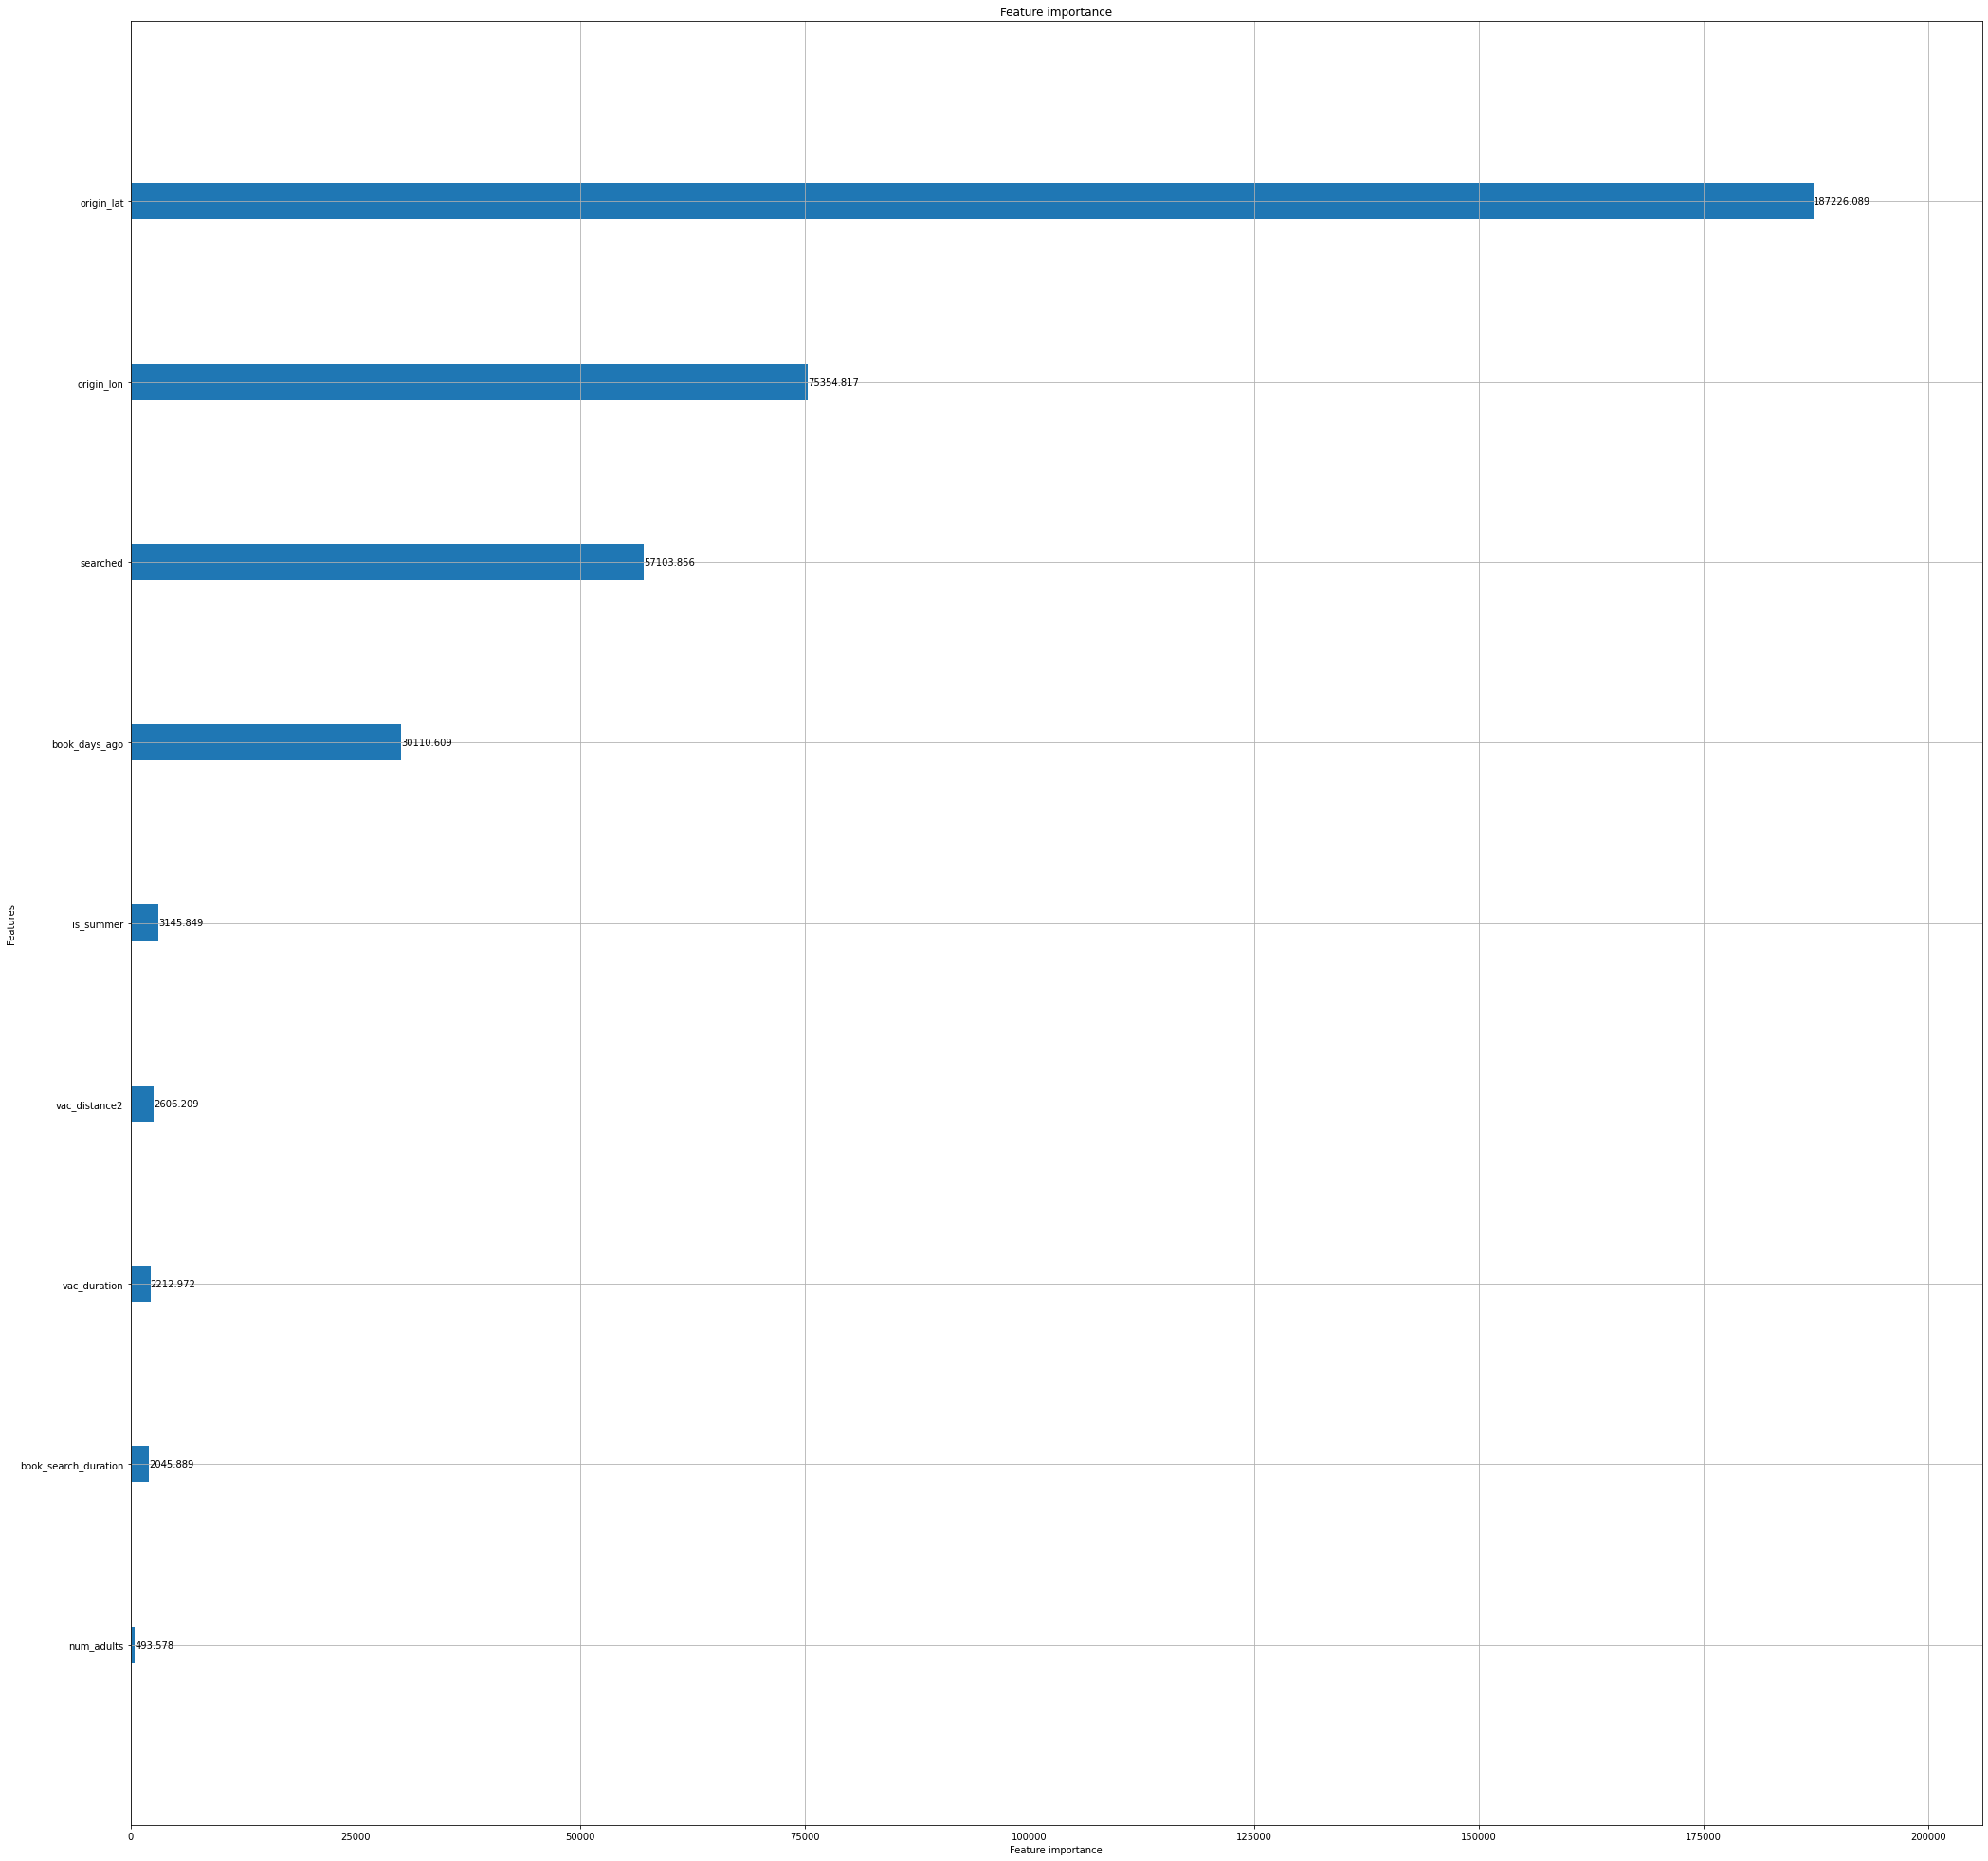

In [215]:
lightgbm.plot_importance(bst, importance_type='gain', figsize=(35, 35))

## Evaluation

In [216]:
#ROC AUC Score Train
y_hat = bst.predict(X_train)
auc_train=roc_auc_score(y_score=y_hat, y_true=y_train)
print(auc_train)

0.9701671544567857


In [217]:
#ROC AUC Score Validation
y_hat = bst.predict(X_val)
auc_val=roc_auc_score(y_score=y_hat, y_true=y_val)
print(auc_val)


0.969158505878801


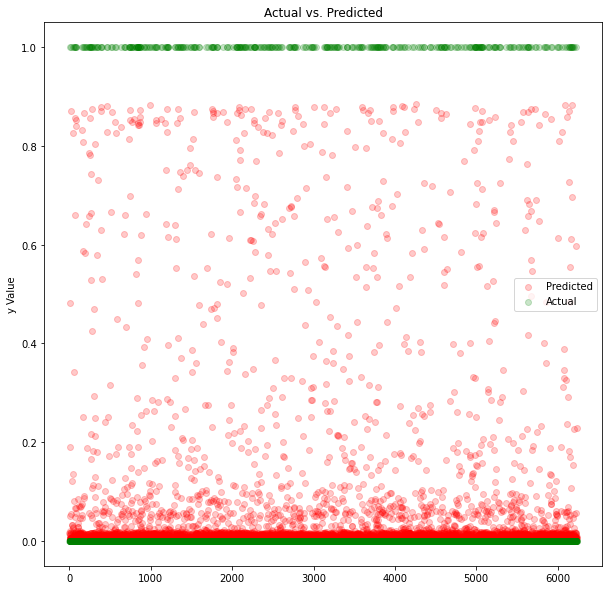

In [218]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(x = range(0, y_hat.size), y=y_hat, c = 'red', label = 'Predicted', alpha = 0.21)
ax.scatter(x = range(0, y_val.size), y=y_val, c = 'green', label = 'Actual', alpha = 0.21)
plt.title('Actual vs. Predicted')
plt.ylabel('y Value')
plt.legend()
plt.show()

In [219]:

print(f"Minimum predicted booking likelihood is %{(y_hat.min()*100):1.7f} maximum predicted booking likelihood is %{(y_hat.max()*100):1.7f}")

Minimum predicted booking likelihood is %0.3709432 maximum predicted booking likelihood is %88.5197596


In [232]:
#RMSE Train
y_hat = bst.predict(X_train)
rms_train = mean_squared_error(y_train, y_hat)
print(rms_train)

0.02340685374615384


In [235]:
#RMSE Validation
y_hat = bst.predict(X_val)
rms_val = mean_squared_error(y_val, y_hat)
print(rms_val)

0.0234668823774451


In [222]:
#Binary y_hat values
y_bins=[]
for y in y_hat:
    if y<0.5:
        y_bin=0
    else:
        y_bin=1
    y_bins.append(y_bin)
        

In [223]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_bins)
tp=cm[0][0]
fp=cm[1][0]
tn=cm[1][1]
fn=cm[0][1]
print(cm)

[[5822   61]
 [ 128  225]]


In [224]:
#Precision
precision=(tp/(tp+fp))
print(f"Precision for validation dataset is {precision:1.5f}")

Precision for validation dataset is 0.97849


In [225]:
#Accuracy
accuracy=(tp+tn)/(tp+tn+fp+fn)
print(f"Accuracy for validation dataset is {accuracy:1.5f}")

Accuracy for validation dataset is 0.96969


In [237]:
print(f"For validation dataset: AUC is {auc_val:1.5f}, rmse is {rms_val:1.5f}, precision is {precision:1.5f}, accuracy is {accuracy:1.5f} ")

For validation dataset: AUC is 0.96916, rmse is 0.02347, precision is 0.97849, accuracy is 0.96969 


## Cross Validation

In [226]:
cv_results = lightgbm.cv(param, dtrain, num_boost_round=1500, nfold=10, early_stopping_rounds=50,stratified=False)

In [227]:
cv_results=cv_results["binary_logloss-mean"]
print(cv_results)

[0.22153801042549195, 0.22086019223504585, 0.2201276995505339, 0.21944222772222158, 0.2189115982663202, 0.21826895676028452, 0.21814437735891973, 0.21750285958477233, 0.2168651253397314, 0.21616764512954326, 0.21556368003322518, 0.21488119706172332, 0.21438347929819276, 0.21370845069014816, 0.21304261580116357, 0.2129207592256325, 0.2122614194310665, 0.21168721077820427, 0.21119412506671292, 0.21070153411777456, 0.210687260073369, 0.21003921547024035, 0.2093885357922431, 0.20873750854444945, 0.20810106597784506, 0.2075016837401617, 0.2074829891903179, 0.2070033560756424, 0.20639138751014247, 0.2059174487784571, 0.20590095980493195, 0.2054003052203198, 0.20492756807706908, 0.2049169090585957, 0.20430985599077472, 0.2038446354905436, 0.203723567966201, 0.20324087875015268, 0.20278653200100077, 0.20219916812296562, 0.20173261486097843, 0.20112911362706928, 0.2006969809071999, 0.2001300374786807, 0.19968086424061263, 0.1992552449671376, 0.19920984965773808, 0.198637926696208, 0.19860252747

In [228]:
#Summary of CV Results
print(f"According to cross validation results min logloss is {min(cv_results):1.7f} maximum logloss is {max(cv_results):1.7f}, average is {st.mean(cv_results):1.7f} ")

According to cross validation results min logloss is 0.0895635 maximum logloss is 0.2215380, average is 0.1149708 


<AxesSubplot:>

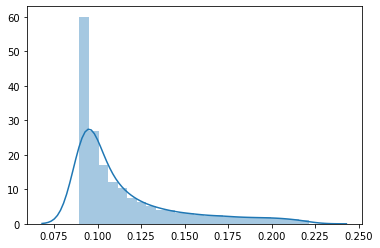

In [229]:
#Distribution of CV Results
sns.distplot(cv_results)

In [230]:
cv_results=pd.DataFrame(cv_results)
cv_results.describe()

,0
count,1500.000000
mean,0.114971
std,0.030916
min,0.089563
25%,0.093186
50%,0.101828
75%,0.124701
max,0.221538
